### Mounting your google drive on Colab Noetebook


In [1]:
from google.colab import drive
## esto te va a pedir autorización. 
# Entra al link. Dale los permisos. Copiate el passw y pegalo acá donde te lo pide
drive.mount('/content/drive')

In [2]:
## remplazá 'unqml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/unqml/ML_UNQ2020/ 

In [3]:
#%cd ../

/home/ariel/repos/ML_UNQ2020


In [4]:
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy.stats import norm
from matplotlib import pyplot as plt
import matplotlib

import scipy.stats as st

%load_ext rpy2.ipython

In [5]:
## Defino Heaviside function

def H(t):
    if(t>0):
        return 1
    elif(t<0):
        return 0
    else:
        return 0.5


In [6]:
N = 100
score = N-np.arange(N)
clase = np.array(['A','B']*int(N/2))
binary_class = (clase == 'A')+0  # 1 si la clase es A, 0 si la clase es B
display(score[0:9])
display(clase[0:9])
display(binary_class[0:9])

array([100,  99,  98,  97,  96,  95,  94,  93,  92])

array(['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A'], dtype='<U1')

array([1, 0, 1, 0, 1, 0, 1, 0, 1])

In [7]:
indA = np.where(clase == 'A')[0]
indB = np.where(clase == 'B')[0]
n1 = len(indA)
n2 = len(indB)
print(n1,n2)

50 50


# AUC: area under curve

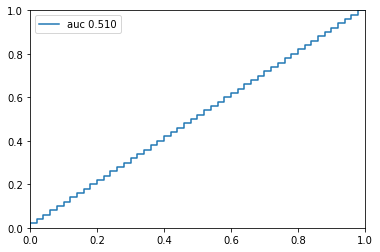

In [8]:
fpr, tpr , _ = metrics.roc_curve(
        y_true=binary_class,
        y_score=score)

auc = metrics.roc_auc_score(binary_class,score)

plt.plot(fpr,tpr,label = 'auc %.3f'%auc)
plt.ylim([0,1])
plt.xlim([0,1])
plt.legend()


### AUC: point estimantion
$
\theta = \frac{1}{n.m} \sum_{i=1}^{n}\sum_{i=j}^{m}{H(X_i - Y_i)}
$

In [9]:
theta_vector = []
for i in indA:
    for j in indB:
        indicator = H(score[i]-score[j])
        theta_vector.append(indicator)
        
display(len(theta_vector))     # Longitud: n1*n2 
display(theta_vector[0:10])    # los primeros
display(theta_vector[-10:-1])  # los últimos


2500

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

[0, 0, 0, 0, 0, 0, 0, 0, 0]

#### Y va a dar...

In [10]:
np.mean(theta_vector)  # Idem que por área bajo la curva

0.51

# Ahora vamos por Mann-Whitney U test

In [11]:
mwu = st.mannwhitneyu(x= score[indA],y= score[indB])  
display(mwu[0])

### mmm
#veamos que pasa con 
mwu = st.mannwhitneyu(x= score[indB],y= score[indA])  
display(mwu[0])

### MMMMM  da igual el estadísitcio U(A,B) = U(B,A) ? 
#No me gusta, vamos con R

1225.0

1225.0

In [12]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

# vamos con R
ro.r('''
wt <- wilcox.test    ### podría haber definido una función arbitraria,
                                        #### pero sólo cargué al entorno global una función del paquete base de R
''')
wilcoxR = ro.globalenv['wt']

In [13]:
mwR = wilcoxR(x=score[indB],y=score[indA])
display(mwR[0][0])


mwR = wilcoxR(x=score[indA],y=score[indB])
display(mwR[0][0])



1225.0

1275.0

### Eso me gusta más, pues la suma de U1+U2 = n1*n2 (la suma de rankings) 

# recordemos
$
AUC = \frac{U_1}{n1*n2}
$

In [14]:
mwR[0][0]/(n1*n2)  ### PERFECTO!!! 


0.51

# Si además queremos ver el IC:

In [15]:
# vamos con R
ro.r('''
install.packages('asht')
library('asht')
wmwTest <- asht::wmwTest 
''')
wmwTest = ro.globalenv['wmwTest']

R[write to console]: Loading required package: exact2x2

R[write to console]: Loading required package: exactci

R[write to console]: Loading required package: ssanv

R[write to console]: Loading required package: bpcp

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: coin



In [16]:
auc_asht = wmwTest(x=score[indB],y=score[indA])

display(auc_asht.rx('statistic')[0])


display(auc_asht.rx('conf.int')[0])


# este paquete implementa para el IC según el paper de Fay and Malinovsky (2018). 
# ojo, el estadístico no fue el U, fue el U normalizado (i.e. directamente el AUC)

0.510000


0.398919,0.619913


## DeLong para IC: 

In [17]:
# vamos con R
ro.r('''
install.packages('pROC')
library('pROC')
auc <- pROC::auc 
ci <- pROC::ci 
''')
auc_pROC = ro.globalenv['auc']
ci_pROC = ro.globalenv['ci']

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [18]:

%R -i score -i binary_class roc_object <- roc(response = binary_class,  predictor = score); 
%R ci_deLong <- pROC::ci(roc_object, of = 'auc');
ci = %R ci_deLong
ci

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



array([0.39571544, 0.51      , 0.62428456])

#### Fijensé que no da igual, pero dio del mismo orden de magnitud que con el método de Fay

# Por último, con este número de clases (n1=50 y n2= 50) Cuál es la zona de aceptación de la H0?

$ U = Z_0 * \sigma_U + \mu_U $

$Z_0 = \phi(1-\alpha/2)$

In [19]:
mu = n1*n2/2
display(mu)

sigma = np.sqrt(n1*n2*(n1+n2+1)/12)
print('std : %.5f'%sigma)
alpha = 0.05

z0=st.norm.ppf(1-alpha/2)
print('Z0 : %.5f'%z0)

1250.0

std : 145.05746
Z0 : 1.95996


In [20]:
U_acept_H0 = [mu-z0*sigma,mu+z0*sigma]
display(U_acept_H0)

AUC_acept_H0 = [u/(n1*n2) for u in U_acept_H0]
display(AUC_acept_H0)

[965.6926029474923, 1534.3073970525077]

[0.3862770411789969, 0.613722958821003]

### Cuyo rango es del mismo orden que la amplitud del IC95% 
# Pero son cosas distintas!!